<a href="https://colab.research.google.com/github/harshavardhangadila/Keras-Hub-and-Teachable-Machines/blob/main/Keras%20Hub%20examples/Text_Based_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Basic Text Classification

In [41]:
# Install required packages
!pip install --quiet tensorflow datasets numpy


In [42]:
# Import Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
# Load IMDb Dataset
dataset = load_dataset("imdb")


In [44]:
# Convert Hugging Face Dataset to DataFrame
df_train = pd.DataFrame(dataset["train"])
df_test = pd.DataFrame(dataset["test"])

# Prepare Training and Testing Data
train_texts = df_train["text"].values
train_labels = df_train["label"].values
test_texts = df_test["text"].values
test_labels = df_test["label"].values

In [45]:
# Initialize Tokenizer
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

# Convert text to sequence of tokens
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [46]:
# Apply Padding to all sequences
max_len = 200
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [47]:
# Define LSTM-based Sentiment Classification Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Output layer for binary classification
])

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [48]:
# Train the model
model.fit(train_padded, train_labels, validation_data=(test_padded, test_labels), epochs=3, batch_size=64)


Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 203ms/step - accuracy: 0.5041 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 199ms/step - accuracy: 0.4975 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 209ms/step - accuracy: 0.4958 - loss: 0.6932 - val_accuracy: 0.4957 - val_loss: 0.6931


In [49]:
# Evaluate model with classification report
def evaluate_model():
    preds = (model.predict(test_padded) > 0.5).astype("int32").flatten()
    print("Model Evaluation on Test Set:\n")
    print(classification_report(test_labels, preds, target_names=["Negative", "Positive"]))
    print("Confusion Matrix:\n", confusion_matrix(test_labels, preds))


In [50]:

# Predict Sentiment from raw text input
def predict_sentiment(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    predictions = model.predict(padded)

    for i, text in enumerate(texts):
        sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
        confidence = float(predictions[i])
        preview = text[:100].strip().replace('\n', ' ')
        print(f"Review Snippet: \"{preview}...\" → Sentiment: {sentiment} (Confidence: {confidence:.2f})")



In [51]:
# Sample Reviews for Sentiment Prediction
sample_reviews = [
    "This movie was amazing! The story and visuals were fantastic!",
    "It was decent, but nothing too special.",
    "Great acting and direction. Loved it from start to finish."
]

predict_sentiment(sample_reviews)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Review Snippet: "This movie was amazing! The story and visuals were fantastic!..." → Sentiment: Negative (Confidence: 0.50)
Review Snippet: "It was decent, but nothing too special...." → Sentiment: Negative (Confidence: 0.50)
Review Snippet: "Great acting and direction. Loved it from start to finish...." → Sentiment: Negative (Confidence: 0.50)


<ipython-input-50-23520c2a0f74>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(predictions[i])


In [52]:
# Evaluate model on test data
evaluate_model()

782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step
Model Evaluation on Test Set:

              precision    recall  f1-score   support

    Negative       0.50      0.56      0.53     12500
    Positive       0.50      0.43      0.46     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.49     25000
weighted avg       0.50      0.50      0.49     25000

Confusion Matrix:
 [[6970 5530]
 [7078 5422]]


# 2. Intermediate Text Classification

In [4]:
# Install required libraries
!pip install --quiet tensorflow datasets transformers matplotlib seaborn

In [5]:
# Import necessary packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

In [6]:
# Enable XLA acceleration to speed up training
tf.config.optimizer.set_jit(True)



In [7]:
# Load AG News dataset from Hugging Face
dataset = load_dataset("ag_news")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:

# Convert the dataset into a Pandas DataFrame
df = pd.DataFrame(dataset['train'])
df.columns = ['text', 'label']
df['label'] = df['label'].astype(int)

In [9]:
# Use only 10% of the dataset for faster training
df = df.sample(frac=0.1, random_state=42)

# Define class labels for better readability
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Science/Technology"}
df['category'] = df['label'].map(label_map)

In [10]:
# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values, df['label'].values, test_size=0.2, stratify=df['label'], random_state=42
)

# Load pre-trained tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
# Tokenize a batch of text samples
def tokenize_data(texts):
    return tokenizer(list(texts), padding=True, truncation=True, return_tensors="tf")

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)

# Convert tokenized data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), train_labels
)).shuffle(len(train_texts)).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings), val_labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
# Load the DistilBERT model for sequence classification with 4 output classes
bert_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, from_pt=False)

# Set up optimizer and loss function for fine-tuning
optimizer = tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [15]:
from transformers import create_optimizer

# Define total training steps (1 epoch for small dataset)
num_train_steps = len(train_dataset)  # Already reduced dataset (10% sampled)
num_warmup_steps = 0

# Create AdamW optimizer and learning rate schedule
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=0.01
)

# Re-compile the model with the new optimizer
bert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

history = bert_model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(10),
    epochs=1
)

10/10 [==============================] - 660s 66s/step - loss: 1.3490 - accuracy: 0.4500 - val_loss: 1.2792 - val_accuracy: 0.5719


In [17]:
test_loss, test_accuracy = bert_model.evaluate(val_dataset.take(10))
print(f"\nFinal validation accuracy (on 30 batches): {test_accuracy:.4f}")

10/10 [==============================] - 150s 15s/step - loss: 1.2792 - accuracy: 0.5719

Final validation accuracy (on 30 batches): 0.5719


In [20]:
# Define prediction function for new samples
def predict_news(text_samples):
    encodings = tokenize_data(text_samples)
    logits = bert_model.predict(dict(encodings)).logits
    predicted_classes = np.argmax(logits, axis=1)
    for i, text in enumerate(text_samples):
        preview = text[:100].strip().replace('\n', ' ')
        print(f"Input text: \"{preview}...\" → Predicted class: {label_map[predicted_classes[i]]}")

# Provide some sample news headlines for prediction
sample_news = [
    "The stock market crashes amid economic concerns.",
    "Manchester United wins the Champions League final!",
    "New advancements in artificial intelligence are reshaping technology."
]

# Call prediction function
predict_news(sample_news)

1/1 [==============================] - 0s 148ms/step
Input text: "The stock market crashes amid economic concerns...." → Predicted class: World
Input text: "Manchester United wins the Champions League final!..." → Predicted class: Sports
Input text: "New advancements in artificial intelligence are reshaping technology...." → Predicted class: Science/Technology


# 3. Advance_Text Classification

In [21]:
# Install required libraries
!pip install --quiet tensorflow datasets transformers scikit-learn

In [22]:
# Import necessary modules
import tensorflow as tf
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import TFAutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split

In [23]:
# Load IMDb dataset
dataset = load_dataset("imdb")

In [24]:
# Convert to DataFrame and sample a smaller portion for quick training
df = pd.DataFrame(dataset['train'])
df = df[['text', 'label']]
df = df.sample(frac=0.05, random_state=42)  # Use only 5% of data
df['label'] = df['label'].astype(int)

In [25]:
# Add a second label for review length
df['length_category'] = df['text'].apply(lambda x: 0 if len(x) < 100 else (1 if len(x) < 300 else 2))

# Load tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [26]:
# Tokenize text data
def tokenize_data(texts):
    return tokenizer(list(texts), padding="max_length", truncation=True, max_length=128, return_tensors="tf")

# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].values,
    df[['label', 'length_category']].values,
    test_size=0.2,
    random_state=42
)

In [27]:
train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)

# Separate sentiment and length labels
train_sentiment_labels = np.array([label[0] for label in train_labels])
train_length_labels = np.array([label[1] for label in train_labels])
val_sentiment_labels = np.array([label[0] for label in val_labels])
val_length_labels = np.array([label[1] for label in val_labels])

In [28]:
# Use small batch size for quicker execution
BATCH_SIZE = 8

# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    {"sentiment_output": train_sentiment_labels, "length_output": train_length_labels}
)).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
    {"sentiment_output": val_sentiment_labels, "length_output": val_length_labels}
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [29]:
# Load RoBERTa base model
roberta_model = TFAutoModel.from_pretrained("roberta-base", return_dict=True)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [30]:
# Build a dual-output classification model
def build_model():
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    roberta_outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_output = tf.keras.layers.Lambda(lambda x: x.last_hidden_state[:, 0, :])(roberta_outputs)
    dense = tf.keras.layers.Dense(128, activation="relu")(cls_output)
    dropout = tf.keras.layers.Dropout(0.3)(dense)
    sentiment_output = tf.keras.layers.Dense(1, activation="sigmoid", name="sentiment_output")(dropout)
    length_output = tf.keras.layers.Dense(3, activation="softmax", name="length_output")(dropout)
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[sentiment_output, length_output])


In [31]:
# Compile the model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss={"sentiment_output": "binary_crossentropy", "length_output": "sparse_categorical_crossentropy"},
    metrics={"sentiment_output": "accuracy", "length_output": "accuracy"}
)

In [33]:
# Train the model briefly
history = model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(10),
    epochs=1
)

10/10 [==============================] - 137s 14s/step - loss: 0.9110 - sentiment_output_loss: 0.7682 - length_output_loss: 0.1428 - sentiment_output_accuracy: 0.5000 - length_output_accuracy: 0.9750 - val_loss: 0.9503 - val_sentiment_output_loss: 0.6842 - val_length_output_loss: 0.2661 - val_sentiment_output_accuracy: 0.5625 - val_length_output_accuracy: 0.9500


In [35]:
# Evaluate performance on limited validation batches
results = model.evaluate(val_dataset.take(10))
test_loss, sentiment_loss, length_loss, sentiment_acc, length_acc = results

10/10 [==============================] - 30s 3s/step - loss: 0.9503 - sentiment_output_loss: 0.6842 - length_output_loss: 0.2661 - sentiment_output_accuracy: 0.5625 - length_output_accuracy: 0.9500


In [36]:
print(f"\nTotal Loss: {test_loss:.4f}")
print(f"Sentiment Accuracy: {sentiment_acc:.4f}")
print(f"Length Category Accuracy: {length_acc:.4f}")


Total Loss: 0.9503
Sentiment Accuracy: 0.5625
Length Category Accuracy: 0.9500


In [37]:
# Predict custom reviews
def predict_reviews(texts):
    encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="tf")
    inputs = {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}
    predictions = model.predict(inputs)
    sentiment_probs = predictions[0].flatten()
    length_classes = np.argmax(predictions[1], axis=1)
    for text, sentiment, length in zip(texts, sentiment_probs, length_classes):
        sentiment_label = "Positive" if sentiment > 0.5 else "Negative"
        length_label = ["Short", "Medium", "Long"][length]
        print(f"Input: \"{text[:100]}...\" → Sentiment: {sentiment_label}, Length: {length_label}")

In [40]:
# Sample reviews - all expressing positive sentiment
sample_reviews = [
    "Absolutely loved this movie! The cinematography and acting were top-notch!",
    "A beautifully written story with stunning visuals and a heartfelt message.",
    "Fantastic performances by the entire cast. Would definitely watch again.",
    "An inspiring and uplifting film that keeps you hooked till the end.",
    "Perfect blend of story, acting, and music. A must-watch masterpiece!"
]

predict_reviews(sample_reviews)

1/1 [==============================] - 2s 2s/step
Input: "Absolutely loved this movie! The cinematography and acting were top-notch!..." → Sentiment: Positive, Length: Long
Input: "A beautifully written story with stunning visuals and a heartfelt message...." → Sentiment: Positive, Length: Long
Input: "Fantastic performances by the entire cast. Would definitely watch again...." → Sentiment: Positive, Length: Long
Input: "An inspiring and uplifting film that keeps you hooked till the end...." → Sentiment: Positive, Length: Long
Input: "Perfect blend of story, acting, and music. A must-watch masterpiece!..." → Sentiment: Positive, Length: Long


# 4. Expert: Text Classification

In [53]:
# Install dependencies if needed
!pip install --quiet tensorflow tensorflow_datasets matplotlib seaborn scikit-learn

# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
from sklearn.metrics import confusion_matrix, classification_report

In [54]:
# Load the IMDB dataset, split to simulate production deployment
(raw_train, raw_test), info = tfds.load(
    'imdb_reviews',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

# Define tokenizer parameters
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 200

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.C67066_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.C67066_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.C67066_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [55]:
# Create a text vectorizer
vectorizer = layers.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=SEQUENCE_LENGTH)
train_texts = raw_train.map(lambda x, y: x)
vectorizer.adapt(train_texts)

In [56]:
# Preprocessing function: tokenize text and add normalized text length
def encode_sample(text, label):
    tokenized_text = vectorizer(text)
    text_len = tf.strings.length(text, unit='UTF8_CHAR')
    aux_feature = tf.cast(text_len, tf.float32) / 1000.0  # Normalize for better learning
    return (tokenized_text, tf.reshape(aux_feature, [-1])), label

# Batch and optimize datasets
BATCH_SIZE = 32
train_dataset = raw_train.map(encode_sample).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = raw_test.map(encode_sample).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [57]:
# Define the dual-input LSTM model with text and auxiliary features
def build_model():
    text_input = layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='text_input')
    aux_input = layers.Input(shape=(1,), name='aux_input')

    embedded_text = layers.Embedding(VOCAB_SIZE, 128)(text_input)
    lstm_output = layers.Bidirectional(layers.LSTM(64))(embedded_text)
    dense_text = layers.Dense(64, activation='relu')(lstm_output)

    dense_aux = layers.Dense(16, activation='relu')(aux_input)

    combined = layers.concatenate([dense_text, dense_aux])
    hidden = layers.Dense(32, activation='relu')(combined)
    output = layers.Dense(1, activation='sigmoid')(hidden)

    return Model(inputs=[text_input, aux_input], outputs=output)

In [59]:
# Initialize and compile the model
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Run a brief training for demonstration
history = model.fit(
    train_dataset.take(20),             # Limit to 200 batches for speed
    validation_data=test_dataset.take(10),
    epochs=1                             # One epoch for fast experimentation
)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.4884 - loss: 0.7051 - val_accuracy: 0.5500 - val_loss: 0.6901


In [60]:
# Evaluate on a subset of the test data
test_loss, test_accuracy = model.evaluate(test_dataset.take(50))
print(f"\nModel Performance - Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5301 - loss: 0.6920

Model Performance - Test Accuracy: 0.5169 | Test Loss: 0.6932


In [61]:
# Collect predictions for visualization
true_labels = []
predicted_labels = []

for (token_batch, length_batch), labels in test_dataset.take(30):
    predictions = model.predict([token_batch, length_batch])
    predicted_classes = (predictions.flatten() > 0.5).astype(int)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━

In [62]:
# Display confusion matrix and classification metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive"])

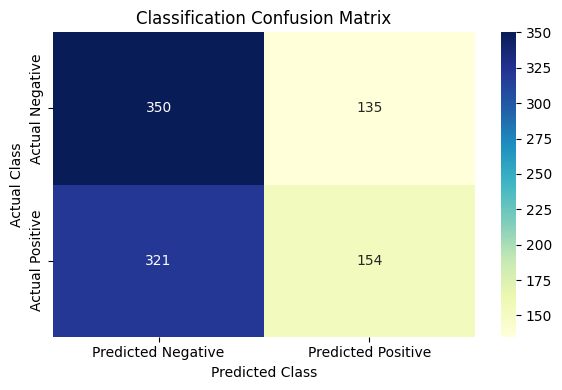

In [63]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Classification Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

In [64]:
# Output the classification report
print("Detailed Classification Report:\n")
print(class_report)

Detailed Classification Report:

              precision    recall  f1-score   support

    Negative       0.52      0.72      0.61       485
    Positive       0.53      0.32      0.40       475

    accuracy                           0.53       960
   macro avg       0.53      0.52      0.50       960
weighted avg       0.53      0.53      0.51       960

